In [9]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels as sm
import numpy as np
#From here, I rely heavily on this tutorial: https://www.youtube.com/watch?v=2XGSIlgUBDI
from statsmodels.tsa.stattools import adfuller

In [10]:
#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
seattle = pd.read_csv('FullSet_clean.csv')
seattle.head()

,Year,Month,Precinct,Sector,Beat,Total_calls,Avg_response_time,No_action,Assistance,Citation,...,Public_initiated,Alarm,ratio_domestic_to_all_calls,ratio_citation_to_arrest,ratio_911_to_all_calls,ratio_no_action_to_all_calls,ratio_public_to_police_initiated,ratio_assistance_to_all_calls,Day,Date
0,2010,5,SOUTH,OCEAN,O1,478,488.688285,34,201,26,...,180,11,0.010460,1.083333,0.223849,0.071130,0.627178,0.420502,1,2010-05-01
1,2010,10,SOUTHWEST,FRANK,F2,395,892.207595,25,156,39,...,207,9,0.055696,1.695652,0.296203,0.063291,1.156425,0.394937,1,2010-10-01
2,2011,2,NORTH,BOY,B3,418,901.270335,36,137,54,...,236,15,0.028708,6.000000,0.296651,0.086124,1.413174,0.327751,1,2011-02-01
3,2012,6,WEST,QUEEN,Q2,461,1774.373102,62,198,28,...,321,20,0.026030,5.600000,0.392625,0.134490,2.675000,0.429501,1,2012-06-01
4,2012,7,NORTH,BOY,B2,603,2312.747927,60,253,34,...,429,19,0.023217,2.000000,0.422886,0.099502,2.767742,0.419569,1,2012-07-01


C:\Users\alain.vandormael\miniconda3\envs\py37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


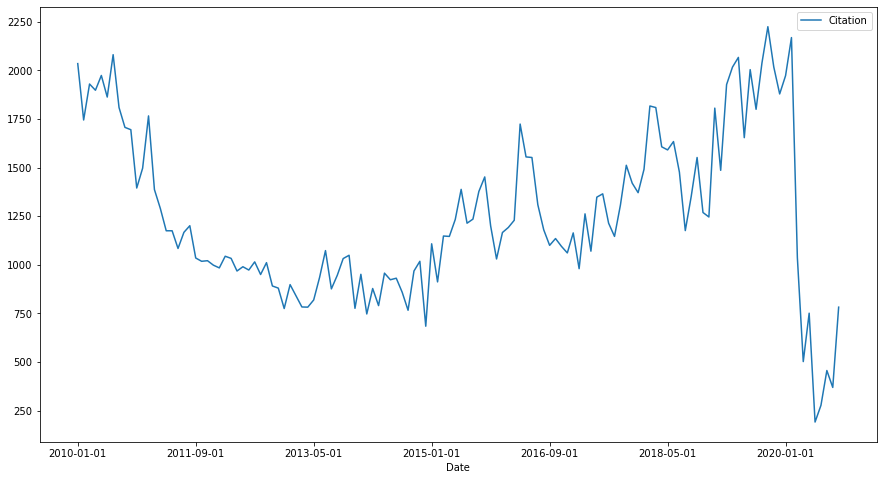

In [49]:
#INPUT YOUR CHOSEN PRECINCT AND FEATURE
feature = 'Citation'
precinct = 'SOUTHWEST'
seattle1 = seattle[seattle['Precinct']==precinct]
seattle1x = seattle[['Date',feature]].groupby('Date').sum(feature).plot(kind='line', figsize=(15,8))

# ARIMA modeling

In [50]:
#Here, we're looking at the Total_calls column
seattleAR=seattle1[['Date',feature]].groupby('Date').sum(feature)
#Set up a fuller test to ensure data is stationary
#Using only months 0:120, since the final 10 months are in 2020, which shouldn't be in our training
test_result=adfuller(seattleAR[feature][0:120])

In [51]:
drops = 0
d = 0
seattleAR['SeasonalDifference']=seattleAR[feature]
adfuller_test(seattleAR['SeasonalDifference'].dropna()[:(120-drops)])

ADF Test Statistic : -5.533297927406499
p-value : 1.7675784788986478e-06
#Lags Used : 5
Number of Observations Used : 114
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [52]:
#print(seattleAR)
#seattleAR['SeasonalDifference'].dropna()[:(120-drops)]

In [53]:
#If not stationary, do differencing to make stationary (shift value = number of months in a seasonal cycle
#If data isn't showing seasonality, can use a shift value of 1 instead.)
seattleAR['SeasonalDifference']=seattleAR['SeasonalDifference']-seattleAR['SeasonalDifference'].shift(12)
drops=12
d = 1
adfuller_test(seattleAR['SeasonalDifference'].dropna()[:(120-drops)])

ADF Test Statistic : -2.779565006306456
p-value : 0.06125257028404284
#Lags Used : 13
Number of Observations Used : 94
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [54]:
#print(seattleAR)
#each drops removes a year 
seattleAR['SeasonalDifference'].dropna()[:(120-drops)]

Date
2011-01-01   -74.0
2011-02-01   -30.0
2011-03-01   -57.0
2011-04-01   -90.0
2011-05-01   -81.0
              ... 
2019-08-01    18.0
2019-09-01    17.0
2019-10-01     1.0
2019-11-01   -22.0
2019-12-01   -27.0
Name: SeasonalDifference, Length: 108, dtype: float64

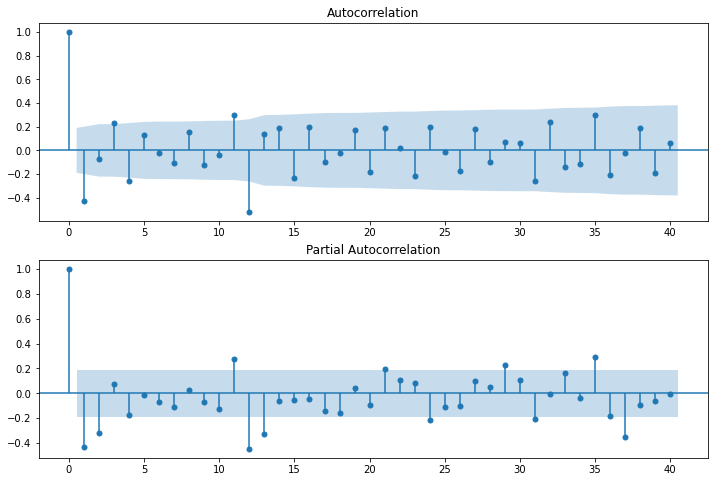

In [56]:
#View the autocorrelation and partial autocorrelation plots in order to determine p and q weights
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seattleAR['SeasonalDifference'].dropna()[0:(120-drops)],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seattleAR['SeasonalDifference'].dropna()[0:(120-drops)],lags=40,ax=ax2)

In [31]:
#select p=2, d=1, q=7(p is because in bottom chart, partial autocorrelation above drops into 'normal' 
#range after first 2 points; q is because top chart, autocorrelation, sees the exponential drop reach
#its lowest positive point at 4, and d is because I only did one shift (of 12 months))